# Steps

In [187]:
# SIFT Feature Extraction:

# SIFT features (descriptors) are extracted from all the images.
# For each image, we extract multiple SIFT descriptors.
# Each SIFT descriptor is a high-dimensional vector (typically of length 128).

In [188]:
# Clustering with KMeans:

# We use KMeans clustering to group these SIFT descriptors into clusters.
# Each cluster represents a visual word in our visual vocabulary.
# The number of clusters k we choose determines how many visual words we have in our vocabulary.

# In this case, we set k=2, meaning we want to create 2 visual words.

In [189]:
# Visual Vocabulary: (Bag Of Visual Words)

# After KMeans clustering, we get k cluster centers.
# These centers are the centroids of the clusters in the 128-dimensional space of SIFT descriptors.

# For k=2, we get 2 cluster centers, each a vector of length 128.

# Example:

# Cluster 1: Center might represent a common pattern found in both cat and dog images, such as fur texture.
# Cluster 2: Center might represent another pattern, such as ear shape.

In [190]:
# Histogram Representation:

# For each image, we convert its SIFT descriptors into one histogram of visual words.
# This histogram indicates how many descriptors fall into each cluster (visual word).
# So each image has one histogram.


# Steps:

# Extract SIFT descriptors for an image.
# Assign each descriptor to the nearest cluster center (visual word).
# Create a histogram where each bin counts how many descriptors fall into each cluster.
# For example, if we have k=2:

# Image 1 (Cat):
#        - 10 descriptors assigned to Cluster 1
#        - 20 descriptors assigned to Cluster 2
#        - Histogram: [10, 20]

# Image 2 (Dog):
#        - 15 descriptors assigned to Cluster 1
#        - 25 descriptors assigned to Cluster 2
#        - Histogram: [15, 25]

# These histograms are the feature vectors used to train the classifier.

In [191]:
# Training the SVM Classifier:

# We train an SVM classifier using these histogram features:

# X_train: Histograms for the training images.
# y_train: Labels (0 for cats, 1 for dogs).

# Imports

In [192]:
import os
import shutil
import random
import cv2
import numpy as np
import shutil
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Dataset Preperation

In [193]:
# delete the sampled_dataset directory/
shutil.rmtree('sampled_dataset', ignore_errors=True)

In [194]:
# Dataset directories
TRAIN_DIR_DOGS = './archive/dataset/training_set/dogs/'
TRAIN_DIR_CATS = './archive/dataset/training_set/cats/'
TEST_DIR_DOGS = './archive/dataset/test_set/dogs/'
TEST_DIR_CATS = './archive/dataset/test_set/cats/'

In [195]:
# Function to load and sample dataset paths.
def load_and_sample_dataset_paths(train_sample_size, test_sample_size):
    # Crate a list of paths to all images in the dataset.
    train_images_dogs = [TRAIN_DIR_DOGS + i for i in os.listdir(TRAIN_DIR_DOGS)]
    train_images_cats = [TRAIN_DIR_CATS + i for i in os.listdir(TRAIN_DIR_CATS)]
    test_images_dogs = [TEST_DIR_DOGS + i for i in os.listdir(TEST_DIR_DOGS)]
    test_images_cats = [TEST_DIR_CATS + i for i in os.listdir(TEST_DIR_CATS)]
    
    # Now take samples from the list of paths.
    train_images_dogs_sample = random.sample(train_images_dogs, train_sample_size)
    train_images_cats_sample = random.sample(train_images_cats, train_sample_size)
    test_images_dogs_sample = random.sample(test_images_dogs, test_sample_size)
    test_images_cats_sample = random.sample(test_images_cats, test_sample_size)


    print('Train Dogs:', len(train_images_dogs_sample))
    print('Train Cats:', len(train_images_cats_sample))
    print('Test Dogs:', len(test_images_dogs_sample))
    print('Test Cats:', len(test_images_cats_sample))

    return train_images_dogs_sample, train_images_cats_sample, test_images_dogs_sample, test_images_cats_sample

In [196]:
# Set sample size.
train_sample_size = 500
test_sample_size = 100

train_images_dogs, train_images_cats, test_images_dogs, test_images_cats = load_and_sample_dataset_paths(train_sample_size, test_sample_size)

Train Dogs: 500
Train Cats: 500
Test Dogs: 100
Test Cats: 100


In [197]:
# Function to create a directory structure of the sampled dataset by copying files
def create_sampled_directory_structure(train_images_dogs, train_images_cats, test_images_dogs, test_images_cats, base_dir='./sampled_dataset/'):

    train_dir = os.path.join(base_dir, 'training_set')
    test_dir = os.path.join(base_dir, 'test_set')
    
    train_dogs_dir = os.path.join(train_dir, 'dogs')
    train_cats_dir = os.path.join(train_dir, 'cats')
    test_dogs_dir = os.path.join(test_dir, 'dogs')
    test_cats_dir = os.path.join(test_dir, 'cats')
    

    # Create the new directory structure IF they do not exist.
    os.makedirs(train_dogs_dir, exist_ok=True)
    os.makedirs(train_cats_dir, exist_ok=True)
    os.makedirs(test_dogs_dir, exist_ok=True)
    os.makedirs(test_cats_dir, exist_ok=True)
    
    
    # Copy the original image files to this new sampled directory structure.
    for img_path in train_images_dogs:
        shutil.copy2(img_path, os.path.join(train_dogs_dir, os.path.basename(img_path)))
    for img_path in train_images_cats:
        shutil.copy2(img_path, os.path.join(train_cats_dir, os.path.basename(img_path)))
    for img_path in test_images_dogs:
        shutil.copy2(img_path, os.path.join(test_dogs_dir, os.path.basename(img_path)))
    for img_path in test_images_cats:
        shutil.copy2(img_path, os.path.join(test_cats_dir, os.path.basename(img_path)))


    # Show the sample sizes of all sets used.
    print('Train Dogs:', len(os.listdir(train_dogs_dir)))
    print('Train Cats:', len(os.listdir(train_cats_dir)))
    print('Test Dogs:', len(os.listdir(test_dogs_dir)))
    print('Test Cats:', len(os.listdir(test_cats_dir)))
    
    return train_dir, test_dir

In [198]:
# Create sampled directory structure (call the function)
sampled_train_data_dir, sampled_test_data_dir = create_sampled_directory_structure(train_images_dogs, train_images_cats, test_images_dogs, test_images_cats)

Train Dogs: 500
Train Cats: 500
Test Dogs: 100
Test Cats: 100


# Data Preprocessing

In [199]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Creating training and validation sets
train_generator = train_datagen.flow_from_directory(
    sampled_train_data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
)

# Creating test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    sampled_test_data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


# Feature Extraction Using SIFT

In [200]:
# Function to extract SIFT features (Descriptors).
def extract_sift_features(image_paths):
    # Initialize a SIFT detector. (this is what we will use to extract features)
    sift = cv2.SIFT_create()
    descriptors = []
    # A Loop to iterate over each image path in "image_paths".
    for path in image_paths:
        # Read an image.
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        # Detect keypoints of an image and compute the descriptors.
        # Keypoints are distinctive image features that can be used to perform matching between different images.
        # (like corners, edges, blobs, etc.)
        kp, des = sift.detectAndCompute(img, None)      # Note: "None" is a placeholder for a mask. We won't use it because we want to detect keypoints in the whole image.
        # Check if descriptors were found in the image.
        if des is not None:
            # Append the descriptors to the list of descriptors.
            descriptors.extend(des)

    return np.array(descriptors)


train_images = train_generator.filepaths
train_descriptors = extract_sift_features(train_images)

# Bag Of Visual Words

In [201]:
# Function to build visual vocabulary.
# We group similar descriptors into clusters, so that we can represent a cluster as a class.

def build_visual_vocabulary(descriptors, k):
    # Initialize the KMeans model.
    kmeans = KMeans(n_clusters=k)
    # Fit the model on the descriptors. (this is the actual finished model with the 2 created clusters)
    kmeans.fit(descriptors)
    
    return kmeans.cluster_centers_

# Number of clusters (labels/ classes) = (cat and dog)
k = 2
visual_vocab = build_visual_vocabulary(train_descriptors, k)
print(visual_vocab.shape)

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(2, 128)


# Histogram Representation

In [202]:
# Function to compute histograms using the bag of words representation.
def compute_histograms(image_paths, sift, visual_vocab):
    histograms = []
    for path in image_paths:
        # Read an image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        # Get the images descriptors.
        kp, des = sift.detectAndCompute(img, None)
        # Check if descriptors were found in the image.
        if des is not None:
            # Initialize a histogram having the same length as the number of clusters
            #   because we want to count how many descriptors fall into each cluster.
            hist = np.zeros(len(visual_vocab))
            # For each descriptor in the image, assign it to the nearest cluster.
            # For this we calculate it using the following method:
            #   - Compute the Euclidean distance between the descriptor and each cluster center.
            #   - Assign the descriptor to the cluster with the minimum distance.
            for d in des:
                # idx is the cluster bin. So we find the cluster with the minimum distance.
                # And we increment the bin's size by 1.
                # So at the end, we will have a histogram showing how many descriptors fall into each cluster.
                #    {min dist.}{           distance calculation        }
                idx = np.argmin(np.linalg.norm(visual_vocab - d, axis=1))
                hist[idx] += 1
            histograms.append(hist)
        else:
            # If no descriptors were found in the image, we append a zero vector.
            histograms.append(np.zeros(len(visual_vocab)))
    return histograms

In [203]:
# Compute histograms for training set images.
train_histograms = compute_histograms(train_images, cv2.SIFT_create(), visual_vocab)

# Compute histograms for test set images.
test_images = test_generator.filepaths
test_histograms = compute_histograms(test_images, cv2.SIFT_create(), visual_vocab)

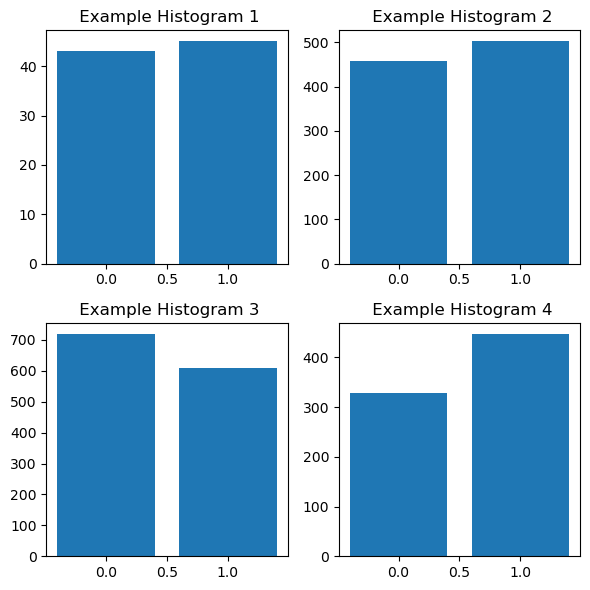

In [204]:
# Select 4 histograms from the test_histograms list.
selected_histograms = test_histograms[:4]

# Create a 2x2 subplot.
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

# Iterate over the selected histograms and plot them in the subplot.
for i, histogram in enumerate(selected_histograms):
   # Plot the histogram in the corresponding subplot.
   axes[i // 2, i % 2].bar(range(len(histogram)), histogram)
   axes[i // 2, i % 2].set_title(f' Example Histogram {i+1}')


plt.tight_layout()
plt.show()


# Mashine Learning Model Implementation (SVM)

In [205]:
# What is the C parameter?
# Its a Regularization tuning parameter.
# It tells the SVM model how much it should missclassify the training data.
# A small C value aims at missclassifying some training data to avoid overfitting and achieve a better generalization.
# A large C value aims at classifying all training data correctly, which can lead to overfitting.

# This is a tuning parameter that should be optimized for the best prediction performance of the model.

In [206]:
# Function to train SVM classifier.
def train_classifier(X_train, y_train, C=1.0):
    # Initialising the SVM classifier.
    classifier = SVC(C=C)
    # Fitting the classifier on the training data.
    classifier.fit(X_train, y_train)
    return classifier

# Get the true labels of the training set.
y_train = train_generator.classes
classifier = train_classifier(train_histograms, y_train)

# Evaluate The Model

In [207]:
# Evaluate classifier on test set.


# Get the true labels of the test set.
y_test = test_generator.classes
# The generator has an internal counter that is incremented every time a batch is drawn.
# We need to reset it before we start extracting the predictions, so that it starts from the beginning.
test_generator.reset()
# Predict the labels of the test set.
y_pred_test = classifier.predict(test_histograms)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy_test)

Test Accuracy: 0.565


# Model Hyperparameter Tuning (Grid Search)

In [208]:
# What is cv?
# It stands for Cross Validation.
# It specifies the number of folds to use in cross-validation.
# So we will train the model 5 times.
# Each time, we split the train data into training and validation sets.
# We train the model on the training set and evaluate it on the validation set.
# Then we continue to the next fold and do the same thing again.
# Each time, a different subset of the data is used for validation while the remaining data is used for training


# This is supposed to give us a more accurate estimate of the model's performance.

In [209]:
# Define the hyperparameter grid.
param_grid = {'C': [0.1, 1, 10, 100]}
# Initialize the GridSearchCV object.
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
# Fit the grid search on the training data.
grid_search.fit(train_histograms, y_train)
# Get the best hyperparameters.
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 0.1}


In [214]:
# Evaluation on test set.

# First, we to calculate the test set histograms.
# We must calculate them again because we reset the test generator.
test_images = test_generator.filepaths
test_histograms = compute_histograms(test_images, cv2.SIFT_create(), visual_vocab)

# Get the true labels of the test set.
y_true = test_generator.classes
# Predict the labels of the test set.
y_pred = classifier.predict(test_histograms)

# Calculate accuracy.
accuracy_test = accuracy_score(y_true, y_pred)
print("Test accuracy:", accuracy_test)
# Calculate recall.
recall_test = recall_score(y_true, y_pred)
print("Test recall:", recall_test)
# Calculate precision.
precision_test = precision_score(y_true, y_pred)
print("Test precision:", precision_test)
# Calculate F1 score.
f1_test = f1_score(y_true, y_pred)
print("Test F1:", f1_test)

Test accuracy: 0.565
Test recall: 0.45
Test precision: 0.5844155844155844
Test F1: 0.5084745762711864


Accuracy: 56.50%

Class: cats
Recall: 68.00%
F1 Score: 60.99%
Precision: 55.28%

Class: dogs
Recall: 45.00%
F1 Score: 50.85%
Precision: 58.44%


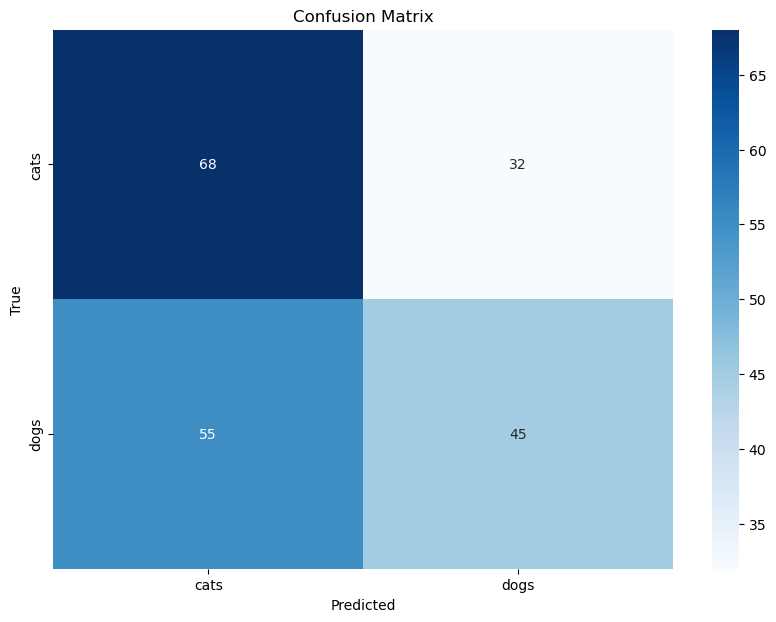

In [213]:
def generate_classification_report(test_generator, classifier):
    # Reset the generator's internal counter.
    test_generator.reset()
    
    # Compute predictions using the classifier.
    y_pred = classifier.predict(test_histograms)
    # Get the true labels from the generator.
    y_true = test_generator.classes
    
    # Generate the confusion matrix.
    cm = confusion_matrix(y_true, y_pred)
    # Calculate accuracy.
    accuracy = accuracy_score(y_true, y_pred)
    # Get class names from the generator.
    class_names = list(test_generator.class_indices.keys())
    # Generate classification report metrics.
    metrics = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    # Print metrics for each class.
    for class_name, values in metrics.items():
        if class_name in class_names:
            print(f"\nClass: {class_name}")
            print(f"Recall: {values['recall'] * 100:.2f}%")
            print(f"F1 Score: {values['f1-score'] * 100:.2f}%")
            print(f"Precision: {values['precision'] * 100:.2f}%")

    # Plot the confusion matrix.
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function with the appropriate arguments.
generate_classification_report(test_generator, classifier)

# Comparison And Analysis

Performance Comparison between the 2 models

In [ ]:
# In our comparison between a machine learning model using a bag-of-words representation
# and a Convolutional Neural Network (CNN), distinct performance trends emerged.
# The CNN model showed superior recall for dogs (68%), indicating its strength in predicting this class.
# However, it struggled with cat predictions, evidenced by its lower recall (31%). Conversely,
# the machine learning model excelled in predicting cats, boasting a higher number of
# true positives (78) for this class. However, its performance in predicting dogs was
# comparatively weaker, with fewer true positives (38). Notably, the CNN model suffered
# from overfitting, as evidenced by its high training accuracy (65.625%) and low validation accuracy (25%).
# In summary, while the CNN model demonstrated better dog predictions,
# the machine learning model was more effective in predicting cats.

Strengths and weaknesses of the model

In [ ]:
# This model fails to predict dogs. It predicts dogs as cats a lot of the time.
# So this model did achieve to learn the features of dogs properly, but it failed to learn the features of cats properly.
# What we did differently here, is that we decreased the input image size from 128x128 to 64x64.
# This could have led to all images being a bit blurry and unclear, so the model was forced to learn all features of the images the same way.
# So it did not matter that cats had unclear distinct features.
# But this might have led to the model not being able to learn the features of dogs properly.

# This model though was able to predict cats successfully.

Identify scenarios where the hybrid approach may be more suitable than using deep learning alone

In [ ]:
# DEFINITION:
# In the context of object classification using machine learning and deep learning,
# the hybrid approach involves using both traditional machine learning techniques,
# like bag-of-words with Support Vector Classifier (SVC),
# and deep learning with Convolutional Neural Networks (CNN) to develop a classification model.


# This hybrid approach might be suitable for situations where there is a lack of labeled data.
# In this case, we do have labeled data, so bag of words might not be necessary.
# Furthermore, SVC is known for generalizing data very well, so it might be a good approach to use here,
# along with the CNN model that we already have.